In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
import os

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Building the Model

In [4]:
# Hyperparameters
learning_rate = 0.01
weight_decay = 1e-4
batch_size = 128
momentum = 0.9
lambda_reg = 0.01

In [5]:
# Helper Functions
def siamese_l1_distance(vectors):
    (h1, h2) = vectors
    return tf.reduce_sum(tf.abs(h1 - h2), axis=1, keepdims=True)

In [6]:
def weight_decay_schedule(epoch):
    return learning_rate * (0.99 ** epoch)

In [7]:
def build_csn(input_shape):
    def convolutional_block(input_shape=None):
        layers_list = [
            layers.Conv2D(64, (3, 3), strides=1, padding='same',
                          kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-2),
                          bias_initializer=tf.keras.initializers.RandomNormal(mean=0.5, stddev=1e-2),
                          kernel_regularizer=regularizers.l2(lambda_reg)),
            layers.ReLU(),
            layers.MaxPooling2D(pool_size=(2, 2), strides=2)
        ]
        if input_shape:
            layers_list.insert(0, layers.Input(shape=input_shape))
        return models.Sequential(layers_list)

    # Define inputs for twin networks
    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)

    # Convolutional layers
    conv_net = models.Sequential([
        convolutional_block(input_shape),
        convolutional_block(),
        convolutional_block()
    ])

    # Shared convolutional layers
    features_a = conv_net(input_a)
    features_b = conv_net(input_b)

    # Flatten features
    features_a = layers.Flatten()(features_a)
    features_b = layers.Flatten()(features_b)

    # Fully connected layer
    fc = layers.Dense(128, activation='sigmoid',
                      kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=2e-1),
                      kernel_regularizer=regularizers.l2(lambda_reg))
    fc_a = fc(features_a)
    fc_b = fc(features_b)

    # Compute L1 distance
    l1_distance = layers.Lambda(siamese_l1_distance)([fc_a, fc_b])

    # Final sigmoid layer for similarity
    output = layers.Dense(1, activation='sigmoid')(l1_distance)

    # CSN Model
    model = models.Model(inputs=[input_a, input_b], outputs=output)
    return model

In [8]:
# Loss Function
@tf.function
def custom_loss(y_true, y_pred):
    ce_loss = -y_true * tf.math.log(y_pred + 1e-8) - (1 - y_true) * tf.math.log(1 - y_pred + 1e-8)
    ce_loss = tf.reduce_mean(ce_loss)
    reg_loss = tf.add_n([tf.nn.l2_loss(var) for var in model.trainable_variables])
    return ce_loss + lambda_reg * reg_loss

In [9]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

In [10]:
# Compile Model
input_shape = (105, 105, 1)
model = build_csn(input_shape)
model.compile(optimizer=optimizer, loss=custom_loss, metrics=['accuracy'])

In [11]:
def train_model(model, train_dataset, val_dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Training loop
        for step, (pair_batch, label_batch) in enumerate(zip(train_pairs, train_labels)):
            input_a_batch = pair_batch[:, 0]  # First image in the pair
            input_b_batch = pair_batch[:, 1]  # Second image in the pair

            # Ensure both images are batches of the same size
            with tf.GradientTape() as tape:
                y_pred = model([input_a_batch, input_b_batch], training=True)  # Pass both inputs
                loss = custom_loss(label_batch, y_pred)

            grads = tape.gradient(loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

            if step % 10 == 0:
                print(f"Step {step}, Loss: {loss.numpy():.4f}")

        # Validation loop
        val_loss, val_acc = model.evaluate(val_dataset)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

In [12]:
# Memory Module (Example Implementation)
def memory_module(query, memory_keys, memory_values):
    similarities = tf.matmul(query, tf.transpose(memory_keys))
    nearest_idx = tf.argmax(similarities, axis=1)
    return tf.gather(memory_values, nearest_idx)

# Importing data and pre processing

In [13]:
data_path = './omniglot_data'

In [14]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

In [15]:
train_dataset = datasets.Omniglot(
    root=data_path,
    background=True,  # Load the background set
    transform=transform,
    download=True
)

Files already downloaded and verified


In [16]:
test_dataset = datasets.Omniglot(
    root=data_path,
    background=False,  # Load the evaluation set
    transform=transform,
    download=True
)


Files already downloaded and verified


In [17]:
# Define indices for splitting the train set into training and validation
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

In [18]:
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

In [19]:
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

In [20]:
print(f"Training Samples: {len(train_subset)}, Validation Samples: {len(val_subset)}")

Training Samples: 15424, Validation Samples: 3856


In [21]:
def generate_pairs(dataset, num_pairs, image_size=(105, 105)):
    pairs = []
    labels = []

    # Randomly sample pairs from the dataset
    for _ in range(num_pairs):
        # Randomly sample two indices
        idx1, idx2 = np.random.choice(len(dataset), 2, replace=False)
        img1, label1 = dataset[idx1]
        img2, label2 = dataset[idx2]

        # Check if they are the same class or not
        same_class = (label1 == label2)

        # Resize and prepare pairs (you can apply the transformation here if necessary)
        img1_resized = tf.image.resize(img1, image_size)
        img2_resized = tf.image.resize(img2, image_size)

        # Append the pair and the label
        pairs.append([img1_resized, img2_resized])
        labels.append(1 if same_class else 0)

    return np.array(pairs), np.array(labels)

In [ ]:
train_pairs, train_labels = generate_pairs(train_dataset, num_pairs=1000)

collab keeps crashing here after using all availble ram

In [ ]:
def create_siamese_dataset(dataset, num_pairs):
    pairs, labels = generate_pairs(dataset, num_pairs)

    dataset_pairs = tf.data.Dataset.from_tensor_slices((pairs, labels))
    dataset_pairs = dataset_pairs.batch(batch_size=128)

    return dataset_pairs

In [ ]:
train_dataset = create_siamese_dataset(train_dataset, num_pairs=1000)
val_dataset = create_siamese_dataset(val_dataset, num_pairs=200)

# Train the model

In [ ]:
train_model(model, train_subset, val_subset, epochs=10)

# Creating a Siemese Network

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
def create_siamese_model(input_shape):
    # Define the base model (shared for both inputs)
    input = layers.Input(shape=input_shape)

    # Example of a simple convolutional base
    x = layers.Conv2D(64, (3, 3), activation="relu")(input)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)

    # Create a model with the defined architecture
    base_model = Model(inputs=input, outputs=x)

    return base_model

def contrastive_loss(y_true, y_pred, margin=1):
    """
    Contrastive loss function to compare the similarity.
    Args:
        y_true: The true labels (0 or 1).
        y_pred: The distance between the feature vectors.
        margin: A margin value for dissimilar pairs.
    Returns:
        Loss value.
    """
    square_pred = tf.square(y_pred)
    margin_square = tf.maximum(margin - y_pred, 0)
    loss = 0.5 * (y_true * square_pred + (1 - y_true) * tf.square(margin_square))
    return tf.reduce_mean(loss)

def create_siamese_network(input_shape):
    # Define input layers for the two inputs of the Siamese network
    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)

    # Create the base model that will be shared
    base_model = create_siamese_model(input_shape)

    # Get the feature embeddings for both inputs
    processed_a = base_model(input_a)
    processed_b = base_model(input_b)

    # Compute the L1 distance between the two embeddings
    distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([processed_a, processed_b])

    # Define the output layer to predict similarity
    output = layers.Dense(1, activation="sigmoid")(distance)

    # Create the full model
    siamese_model = Model(inputs=[input_a, input_b], outputs=output)

    # Compile the model with a loss function and optimizer
    siamese_model.compile(optimizer=Adam(learning_rate=0.0001), loss=contrastive_loss, metrics=["accuracy"])

    return siamese_model


In [3]:
# For demonstration, we'll use MNIST dataset
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Pre-process data (resize and normalize)
X_train = np.expand_dims(X_train, -1)  # Add channel dimension (grayscale)
X_test = np.expand_dims(X_test, -1)
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
# Pair up images and assign labels (1 if they are the same digit, 0 otherwise)
def create_pairs(X, y):
    pairs = []
    labels = []
    digit_indices = [np.where(y == i)[0] for i in range(10)]
    for i in range(len(X)):
        current_image = X[i]
        current_label = y[i]

        # Positive pair: same digit
        same_class_idx = np.random.choice(digit_indices[current_label])
        pairs.append([current_image, X[same_class_idx]])
        labels.append(1)

        # Negative pair: different digit
        diff_class_idx = np.random.choice(np.delete(np.arange(10), current_label))
        diff_class_image = np.random.choice(digit_indices[diff_class_idx])
        pairs.append([current_image, X[diff_class_image]])
        labels.append(0)

    return np.array(pairs), np.array(labels)

In [5]:
# Prepare the training pairs and labels
train_pairs, train_labels = create_pairs(X_train, y_train)
test_pairs, test_labels = create_pairs(X_test, y_test)

In [6]:
# Reshape the pairs for Siamese model input
train_pairs = np.array(train_pairs)
test_pairs = np.array(test_pairs)

In [7]:
# Define the input shape (e.g., 28x28 for MNIST)
input_shape = (28, 28, 1)  # For MNIST dataset

# Create the Siamese network
siamese_model = create_siamese_network(input_shape)

In [8]:
# Train the model
siamese_model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels, batch_size=64, epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.1810 - loss: 0.0614
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.0376 - loss: 0.0153
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.0250 - loss: 0.0102
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.0177 - loss: 0.0074
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.0129 - loss: 0.0055
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.0095 - loss: 0.0043
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.0074 - loss: 0.0034
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.0056 - loss: 0.0027
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.0046 - loss: 0.0022
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.0033 - loss: 0.0018


In [9]:
# Evaluate the model
test_loss, test_acc = siamese_model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f"Test accuracy: {test_acc:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0238 - loss: 0.0092
Test accuracy: 0.0215


In [11]:
import matplotlib.pyplot as plt

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


TypeError: unsupported format string passed to numpy.ndarray.__format__

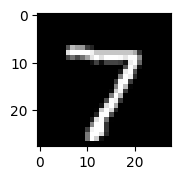

In [13]:
# Make predictions
predictions = siamese_model.predict([test_pairs[:, 0], test_pairs[:, 1]])

# Show some predictions
plt.figure(figsize=(10, 5))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(test_pairs[i, 0].reshape(28, 28), cmap="gray")
    plt.title(f"Pred: {predictions[i]:.2f}")
    plt.axis("off")
plt.show()


In [15]:
# Plot training loss and accuracy
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.legend()
plt.show()

NameError: name 'history' is not defined